## Visualize interrater results

- [ ] get code for loading results for a particular dataset
- [ ] examine the way the code worked for the main paper and copy the structure, it should make taking the plots easier.
- [ ] think about ways to visualize the pixelwise results, maybe just load it and get the plots in a single notebook for expediency.
- [ ] sort out ens not working
- [ ] check why the two forms of GeD are giving the same answer
- [ ] cherck why the error bars are so muich lower for ssn ens on the out of distributuion data

#### Loading all the spreadsheet data

In [8]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from natsort import natsorted
from tqdm import tqdm

In [9]:
results_folder = "./old_results/"
out_domain_results = os.listdir(results_folder)

In [10]:
out_domain_results = [i for i in out_domain_results if ".csv" in i]

In [11]:
#out_domain_results

In [12]:
UNCERTAINTY_TYPES = {
    "SEnt",
    "MC-Drop",
    "Ens",
    "Evid",
    "Ind",
    "P-Unet",
    "SSN",
    "SSN-Ens",
}

In [108]:
def convert_files_to_large_df(folder, filenames, excluded_rows = [], dataset_name="mss3"):
    dfs = []
    for fn in tqdm(natsorted(filenames)):
        if dataset_name not in fn:
            continue
        df = pd.read_csv(os.path.join(folder, fn))
        if "_evid_" in fn:
            uncertainty_type = "Evid"
        elif "_deterministic_" in fn:
            uncertainty_type = "SEnt"
        elif "_ind_" in fn:
            uncertainty_type = "Ind"
        elif "_punet_" in fn:
            uncertainty_type = "P-Unet"
        elif "_ens" in fn and "ssn" not in fn:
            uncertainty_type = "Ens"
        elif "_mc_drop" in fn:
            uncertainty_type = "MC-Drop"
        elif "_ssn_ens_" in fn:
            uncertainty_type = "SSN-Ens"
        elif "_ssn_" in fn and "_ens" not in fn:
            uncertainty_type = "SSN"
        else:
            print("uncertainty type unclear for ", fn)
            continue
            
        cv_fold = fn.split("_")[-2][-1]
        num_samples = fn.split("_")[-1][2:4]
        if num_samples[-1] == '.':
            num_samples = num_samples[:-1]
        
        if len(excluded_rows) > 0:
            df = df.drop(index=excluded_rows, inplace=False)
        df = df.rename(columns = {key:key + f"_ss{num_samples}" for key in df.keys() if key.split("_")[-1][0:2] != "ss" and "Unnamed" not in key})
        df['uncertainty_type'] = [uncertainty_type for _ in range(len(df))]
        df['cv_fold'] = [cv_fold for _ in range(len(df))]
        
        
        dfs.append(df)
    
    return pd.concat(dfs, ignore_index=False)

In [109]:
mss3_df = convert_files_to_large_df(results_folder, out_domain_results, dataset_name="mss3")
lbc_df = convert_files_to_large_df(results_folder, out_domain_results, dataset_name="lbc")
challenge_df = convert_files_to_large_df(results_folder, out_domain_results, dataset_name="challenge")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 810/810 [00:02<00:00, 272.41it/s]


In [110]:
pd.set_option('display.float_format',
      lambda x: '{:,.3f}'.format(x) if abs(x) < 10000 else '{:,.0f}'.format(x))

In [111]:
len(mss3_df)

17550

In [113]:
a = {
    2:{
        "c":np.array([11,12,13,14,15]),
        "d":np.array([22,23,24,25,26])
    },
    3:{
        "a":np.array([1,2,3,4,5]),
        "b":np.array([2,3,4,5,6])
    }
}

In [124]:
np.savez("test.npz", a, allow_pickle=True)

In [128]:
l = np.load("test.npz", allow_pickle=True)

In [129]:
list(l.keys())

['allow_pickle', 'arr_0']

In [130]:
l['arr_0']

array({2: {'c': array([11, 12, 13, 14, 15]), 'd': array([22, 23, 24, 25, 26])}, 3: {'a': array([1, 2, 3, 4, 5]), 'b': array([2, 3, 4, 5, 6])}},
      dtype=object)

In [83]:
mss3_df.to_csv("mss3_combined.csv")

### 95% confidences

In [16]:
from scipy.stats import t as t_distribution
def mean_and_95_conf_over_cvfold(df, metric, return_sem=True):
    cv_scores = df.groupby(['uncertainty_type', 'cv_fold'])[metric].mean().groupby('uncertainty_type')
    mean = cv_scores.mean().rename(f"{metric} mean", axis='index')
    std = cv_scores.std(ddof=1)
    size = cv_scores.size()
    sem_value = std / (np.sqrt(size))
    
    confidence_level = 0.95
    degrees_of_freedom = size - 1
    margin_of_error = t_distribution.ppf((1 + confidence_level) / 2, degrees_of_freedom) * sem_value
    margin_of_error = margin_of_error.rename(f"{metric} 95%")
    sem_value  = sem_value.rename(f"{metric} 95%")
    confidence_interval = (mean - margin_of_error, mean + margin_of_error)
    
    if return_sem:
        return pd.concat([mean, sem_value], axis=1)#, confidence_interval[0], confidence_interval[1]], axis=1)
    else:
        return pd.concat([mean, margin_of_error], axis=1)

In [17]:
SAMPLING_UNCERTAINTY_TYPES = {
    "MC-Drop",
    # "Ens",
    "Ind",
    "P-Unet",
    "SSN",
    "SSN-Ens",
}

In [18]:
import matplotlib.cm as cm 
cmap = cm.Set2
UNCERTAINTY_COLOURS = {
    'Ens':cmap(0),
    'Evid':cmap(1),
    'Ind':cmap(2),
    'MC-Drop':cmap(3),
    'P-Unet':cmap(4),
    'SEnt':cmap(5),
    'SSN':cmap(6),
    'SSN-Ens':cmap(7),
}

In [19]:
from collections import defaultdict
from scipy.stats import t as t_distribution


In [20]:
def plot_metric_as_samples_increase(df, metric, ylabel, title, dolegend, limited_sample_nums=False):
    metric_vals = {}
    if limited_sample_nums:
        sample_nums = [2, 10, 30]
    else:
        sample_nums = [2,3,5,7,10,15,20,25,30]

    dataset_averages = df.groupby(['uncertainty_type', 'cv_fold'])[[f'{metric}_ss{s}' for s in sample_nums]].mean().groupby(['uncertainty_type'])
    mean_score = dataset_averages.mean()
    std = dataset_averages.std()
    size = 6#dataset_averages.size()

    sem_value = std / (np.sqrt(size))
    confidence_level = 0.95
    degrees_of_freedom = size - 1
    # margin_of_error = t_distribution.ppf((1 + confidence_level) / 2, degrees_of_freedom) * sem_value

    for key in SAMPLING_UNCERTAINTY_TYPES:

        # plt.plot(sample_nums, mean_score.loc[key].values, '--', alpha=0.7, color=UNCERTAINTY_COLOURS[key])
        plt.scatter(sample_nums, mean_score.loc[key].values, label=key, zorder=3, color=UNCERTAINTY_COLOURS[key])
        plt.errorbar(sample_nums, mean_score.loc[key].values, yerr= sem_value.loc[key].values,
                     color=UNCERTAINTY_COLOURS[key], capsize=5, linestyle='--', linewidth=2)
    
    if dolegend:
        plt.legend(loc='upper right');

    plt.xlabel("Number of Samples")
    plt.ylabel(ylabel)
    
    # plt.legend(['Line']) 
    plt.title(title)

    # Specify which grid lines  
    plt.grid(axis='both', linestyle='--', linewidth=0.5) 
    
    plt.gca().spines['right'].set_color('none')
    plt.gca().spines['top'].set_color('none')
    

In [21]:
mss3_df.keys()

Index(['Unnamed: 0_ss2', 'rater0_sample_top_dice_ss2',
       'rater0_sample_best_avd_ss2', 'rater1_sample_top_dice_ss2',
       'rater1_sample_best_avd_ss2', 'GED_vol_sorted_ss2',
       'UIRO_curves_t0.00_ss2', 'JUEO_curves_t0.00_ss2',
       'UIRO_curves_t0.01_ss2', 'JUEO_curves_t0.01_ss2',
       ...
       'vds_rater0_sample28_ss30', 'vds_rater1_sample28_ss30',
       'vds_rater_mean_sample28_ss30', 'vds_rater0_sample29_ss30',
       'vds_rater1_sample29_ss30', 'vds_rater_mean_sample29_ss30',
       'sample_vol_skew_ss30', 'GED_dice_sorted_ss30',
       'rater0_best_dice_dsorted_ss30', 'rater1_best_dice_dsorted_ss30'],
      dtype='object', length=1493)

### best dice, best avd and GeD

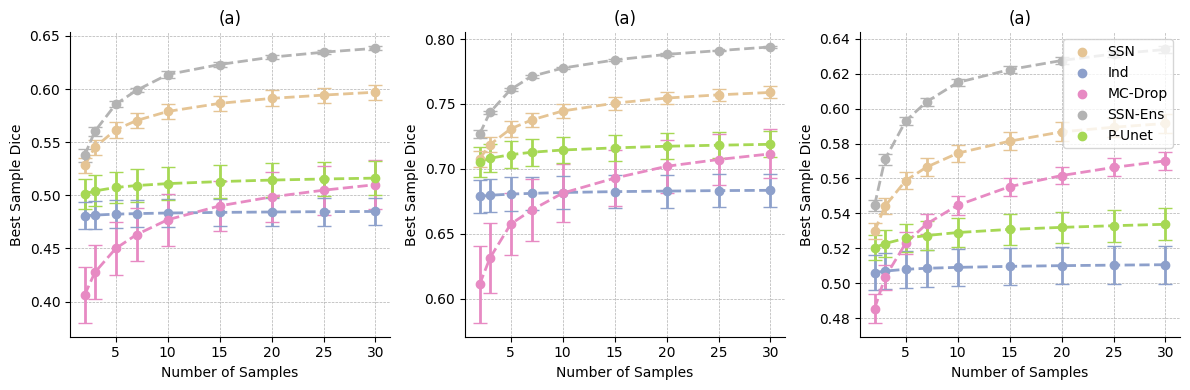

In [22]:
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1)
plot_metric_as_samples_increase(mss3_df, "rater0_best_dice_dsorted", r"Best Sample Dice", "(a)", False)
plt.subplot(1,3,2)
plot_metric_as_samples_increase(lbc_df, "rater0_best_dice_dsorted", r"Best Sample Dice", "(a)", False)
plt.subplot(1,3,3)
plot_metric_as_samples_increase(challenge_df, "rater0_best_dice_dsorted", r"Best Sample Dice", "(a)", True)
plt.tight_layout()

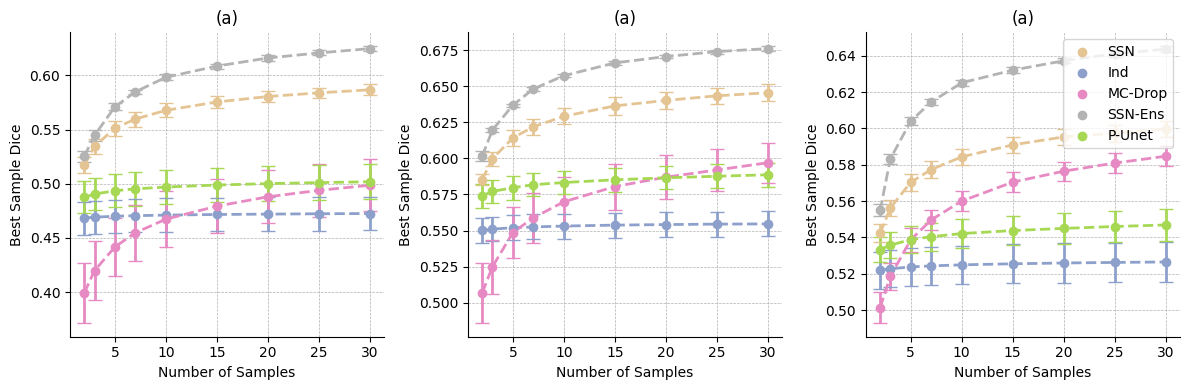

In [23]:
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1)
plot_metric_as_samples_increase(mss3_df, "rater1_best_dice_dsorted", r"Best Sample Dice", "(a)", False)
plt.subplot(1,3,2)
plot_metric_as_samples_increase(lbc_df, "rater1_best_dice_dsorted", r"Best Sample Dice", "(a)", False)
plt.subplot(1,3,3)
plot_metric_as_samples_increase(challenge_df, "rater1_best_dice_dsorted", r"Best Sample Dice", "(a)", True)
plt.tight_layout()

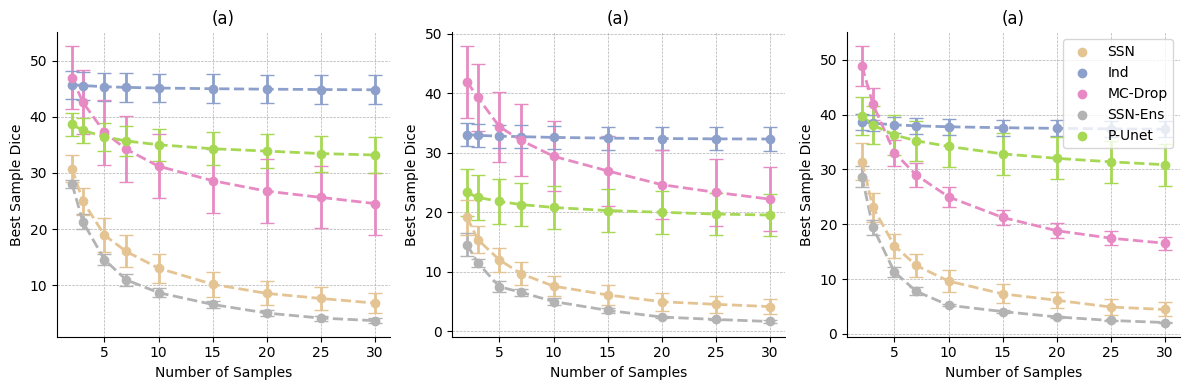

In [24]:
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1)
plot_metric_as_samples_increase(mss3_df, "rater0_sample_best_avd", r"Best Sample Dice", "(a)", False)
plt.subplot(1,3,2)
plot_metric_as_samples_increase(lbc_df, "rater0_sample_best_avd", r"Best Sample Dice", "(a)", False)
plt.subplot(1,3,3)
plot_metric_as_samples_increase(challenge_df, "rater0_sample_best_avd", r"Best Sample Dice", "(a)", True)
plt.tight_layout()

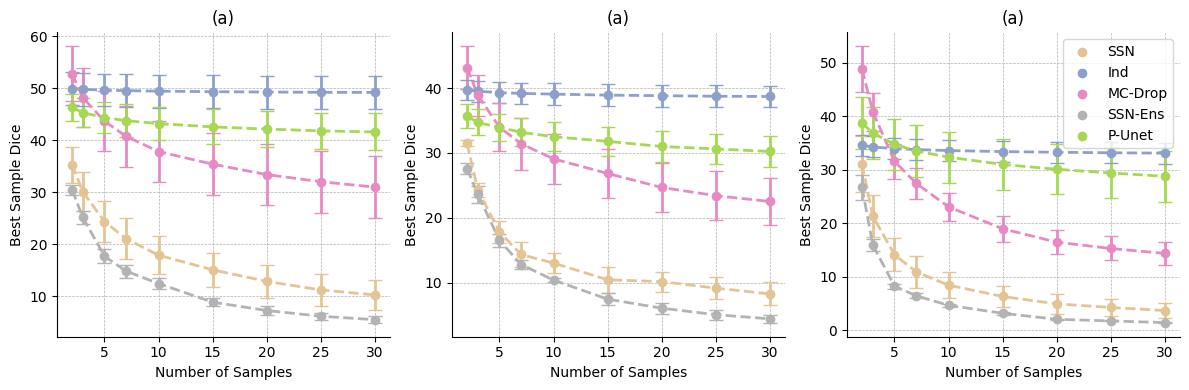

In [25]:
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1)
plot_metric_as_samples_increase(mss3_df, "rater1_sample_best_avd", r"Best Sample Dice", "(a)", False)
plt.subplot(1,3,2)
plot_metric_as_samples_increase(lbc_df, "rater1_sample_best_avd", r"Best Sample Dice", "(a)", False)
plt.subplot(1,3,3)
plot_metric_as_samples_increase(challenge_df, "rater1_sample_best_avd", r"Best Sample Dice", "(a)", True)
plt.tight_layout()

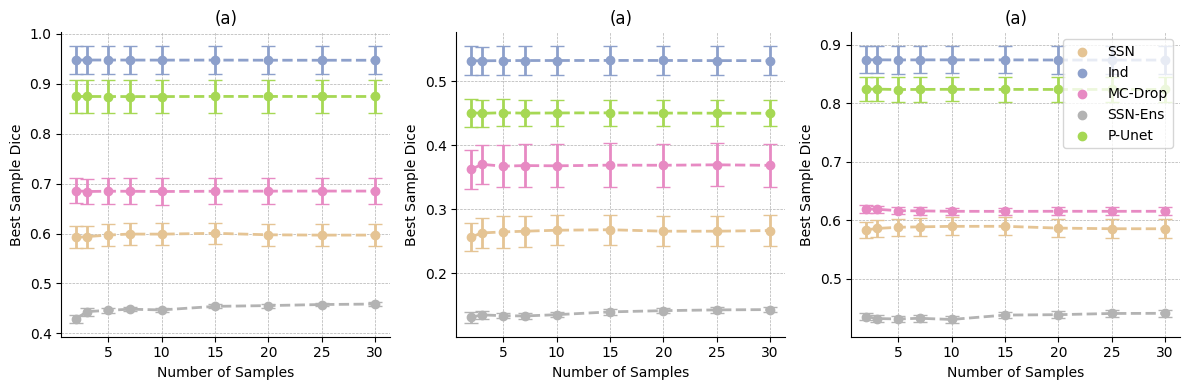

In [26]:
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1)
plot_metric_as_samples_increase(mss3_df, "GED_dice_sorted", r"Best Sample Dice", "(a)", False)
plt.subplot(1,3,2)
plot_metric_as_samples_increase(lbc_df, "GED_dice_sorted", r"Best Sample Dice", "(a)", False)
plt.subplot(1,3,3)
plot_metric_as_samples_increase(challenge_df, "GED_dice_sorted", r"Best Sample Dice", "(a)", True)
plt.tight_layout()

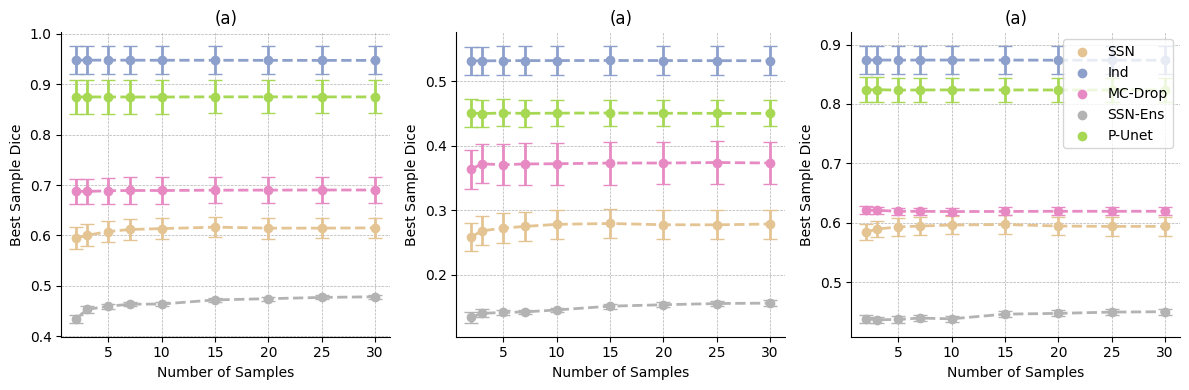

In [27]:
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1)
plot_metric_as_samples_increase(mss3_df, "GED_vol_sorted", r"Best Sample Dice", "(a)", False)
plt.subplot(1,3,2)
plot_metric_as_samples_increase(lbc_df, "GED_vol_sorted", r"Best Sample Dice", "(a)", False)
plt.subplot(1,3,3)
plot_metric_as_samples_increase(challenge_df, "GED_vol_sorted", r"Best Sample Dice", "(a)", True)
plt.tight_layout()

### soft UEO based metrics

so what can we investigate here?

evidential deep learning modelling is essential to capturing information from other raters.
Aleatoric uncertainty is essential for getting a good sample diversity.

When the performance degrades from the best performing model, the UEO is better for SSN Ens, but not Mc Drop or SSN individaully, i.e modelling both epistemic and aleatoric uncertainty together is essential.

Looking at the edge information only is really interesting, MC-Dropout does very well when we get rid of the edges with P-Unet actually performing worst on JUEO when we remove edges. That is very interesting!!!!!

Sometimes punet performans better, sometimes ssn ens.

questions: why is is the edge deducted sJUEO so low? I should look at some images to understand this and explain it for the paper. One visual explanation for each interesting plot that I make.

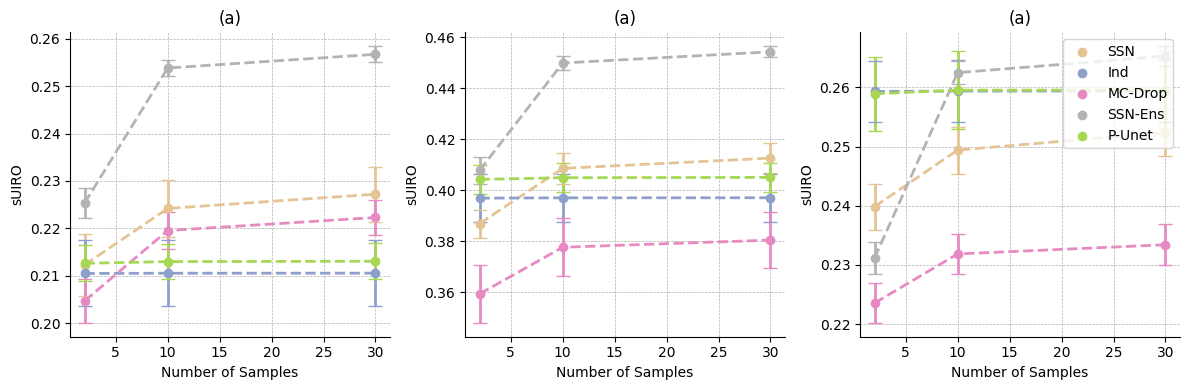

In [28]:
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1)
plot_metric_as_samples_increase(mss3_df, "sUIRO", r"sUIRO", "(a)", False, limited_sample_nums=True)
plt.subplot(1,3,2)
plot_metric_as_samples_increase(lbc_df, "sUIRO", r"sUIRO", "(a)", False, limited_sample_nums=True)
plt.subplot(1,3,3)
plot_metric_as_samples_increase(challenge_df, "sUIRO", r"sUIRO", "(a)", True, limited_sample_nums=True)
plt.tight_layout()

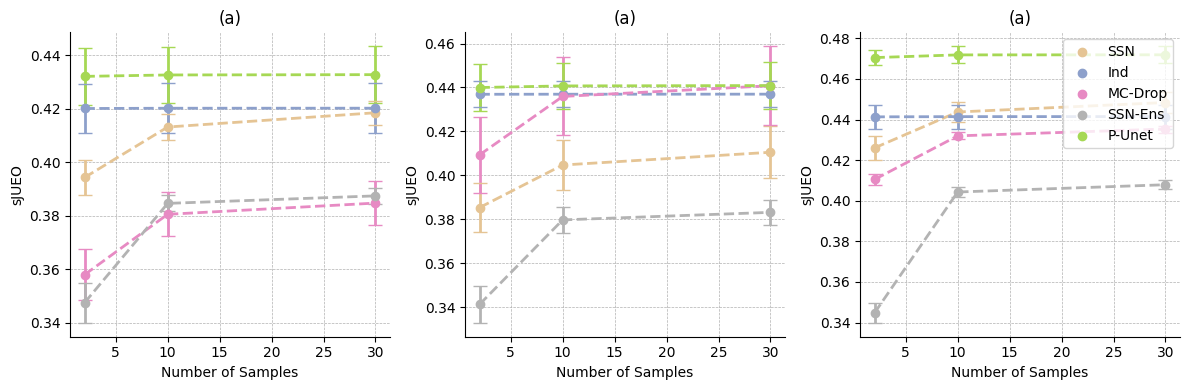

In [29]:
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1)
plot_metric_as_samples_increase(mss3_df, "sJUEO", r"sJUEO", "(a)", False, limited_sample_nums=True)
plt.subplot(1,3,2)
plot_metric_as_samples_increase(lbc_df, "sJUEO", r"sJUEO", "(a)", False, limited_sample_nums=True)
plt.subplot(1,3,3)
plot_metric_as_samples_increase(challenge_df, "sJUEO", r"sJUEO", "(a)", True, limited_sample_nums=True)
plt.tight_layout()

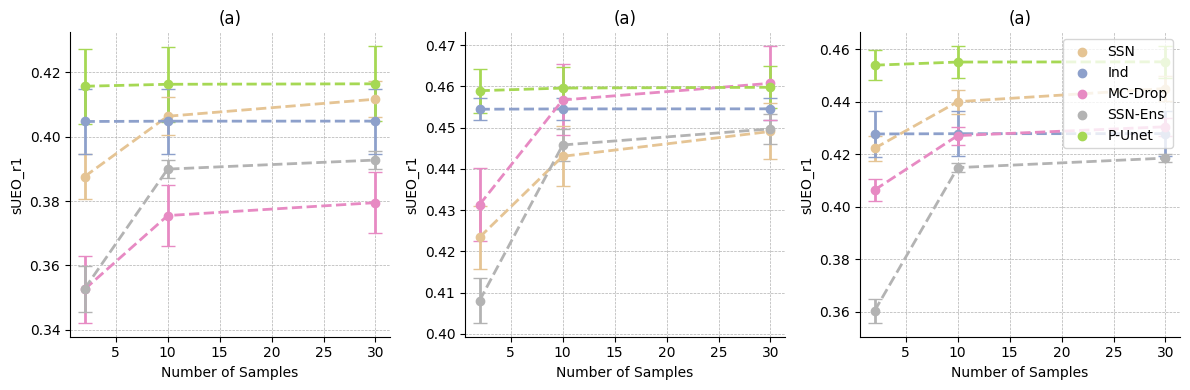

In [30]:
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1)
plot_metric_as_samples_increase(mss3_df, "sUEO_r1", r"sUEO_r1", "(a)", False, limited_sample_nums=True)
plt.subplot(1,3,2)
plot_metric_as_samples_increase(lbc_df, "sUEO_r1", r"sUEO_r1", "(a)", False, limited_sample_nums=True)
plt.subplot(1,3,3)
plot_metric_as_samples_increase(challenge_df, "sUEO_r1", r"sUEO_r1", "(a)", True, limited_sample_nums=True)
plt.tight_layout()

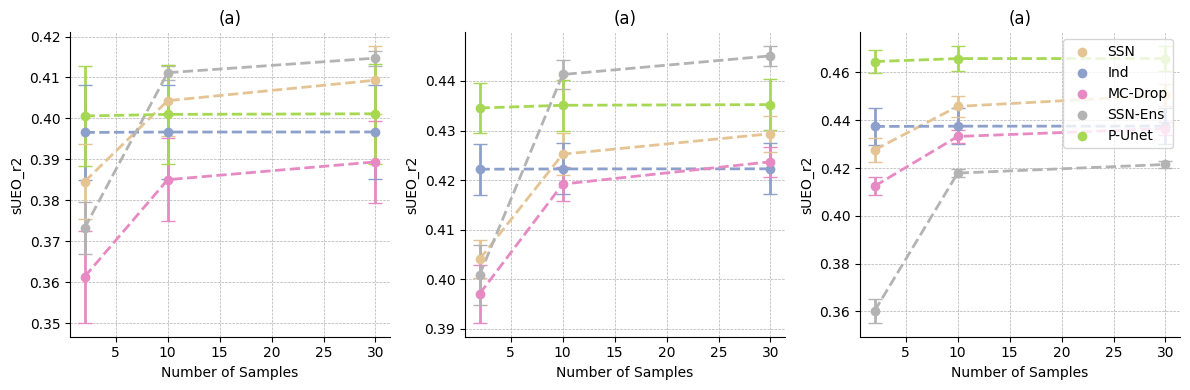

In [31]:
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1)
plot_metric_as_samples_increase(mss3_df, "sUEO_r2", r"sUEO_r2", "(a)", False, limited_sample_nums=True)
plt.subplot(1,3,2)
plot_metric_as_samples_increase(lbc_df, "sUEO_r2", r"sUEO_r2", "(a)", False, limited_sample_nums=True)
plt.subplot(1,3,3)
plot_metric_as_samples_increase(challenge_df, "sUEO_r2", r"sUEO_r2", "(a)", True, limited_sample_nums=True)
plt.tight_layout()

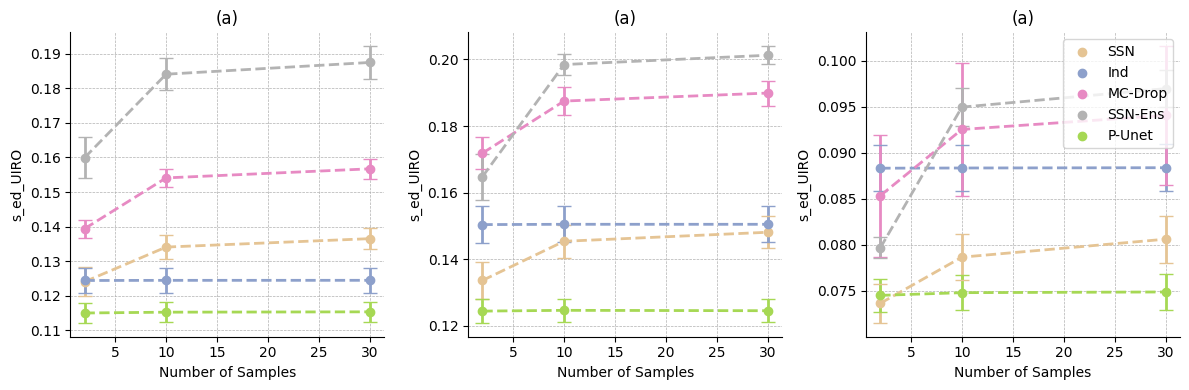

In [32]:
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1)
plot_metric_as_samples_increase(mss3_df, "s_ed_UIRO", r"s_ed_UIRO", "(a)", False, limited_sample_nums=True)
plt.subplot(1,3,2)
plot_metric_as_samples_increase(lbc_df, "s_ed_UIRO", r"s_ed_UIRO", "(a)", False, limited_sample_nums=True)
plt.subplot(1,3,3)
plot_metric_as_samples_increase(challenge_df, "s_ed_UIRO", r"s_ed_UIRO", "(a)", True, limited_sample_nums=True)
plt.tight_layout()

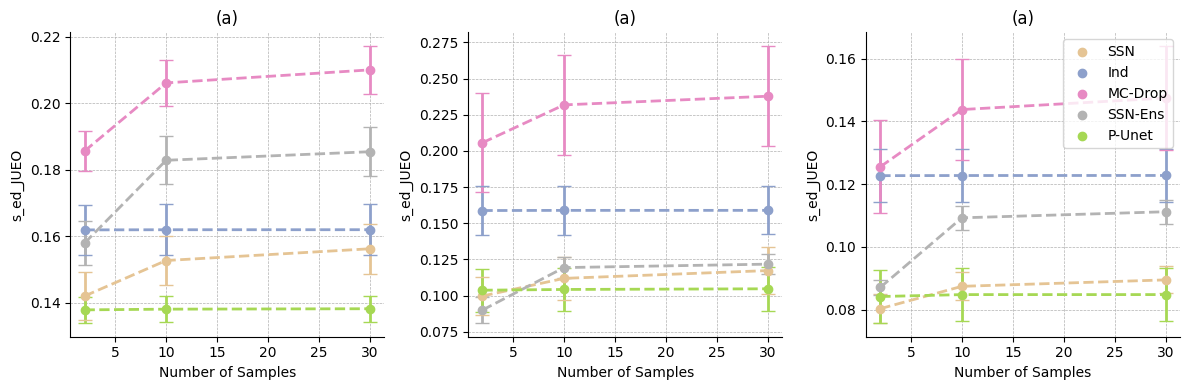

In [33]:
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1)
plot_metric_as_samples_increase(mss3_df, "s_ed_JUEO", r"s_ed_JUEO", "(a)", False, limited_sample_nums=True)
plt.subplot(1,3,2)
plot_metric_as_samples_increase(lbc_df, "s_ed_JUEO", r"s_ed_JUEO", "(a)", False, limited_sample_nums=True)
plt.subplot(1,3,3)
plot_metric_as_samples_increase(challenge_df, "s_ed_JUEO", r"s_ed_JUEO", "(a)", True, limited_sample_nums=True)
plt.tight_layout()

### UIRO JUEO plots

In [34]:
def UEO_at_point(df, get_max=True, at_value=None, max_value=0.7):
    thresholds = np.arange(0, max_value, 0.01)
    column_names = []
    threshold_means = []
    for t in thresholds:
        threshold_means.append(df.groupby(['uncertainty_type', 'cv_fold'])[f"UEO_{t:.2f}"].mean())
        column_names.append(f"UEO_{t:.2f}")
    column_names = np.array(column_names)
    threshold_means = pd.concat(threshold_means, axis=1)
    threshold_cv_means = threshold_means.groupby(['uncertainty_type']).mean()
    
    # find the value on the mean UEO curve that is closest to the target value
    threshold_cv_means = threshold_means.groupby(['uncertainty_type']).mean()
    closest_idx = (threshold_cv_means - at_value).abs().apply(np.argmin, axis=1)
    closest_value = threshold_cv_means.values[np.arange(len(threshold_cv_means)), closest_idx.values]
    
    result_df = pd.DataFrame(closest_idx)
    result_df['ueo_value'] = closest_value
    result_df['threshold'] = thresholds[closest_idx.values]
    
    return result_df

In [35]:
def plot_metric_for_all_thresholds_95(ax, df, metric, ylim=None, xlim=None, title="", ax_title="", marker_point=None, ylabel=None, num_samples=30):
    thresholds = np.arange(0, 0.7, 0.01)
    dfs = []
    # get a mean and conf interval for these curves.
    for tau in thresholds:
        dfs.append(mean_and_95_conf_over_cvfold(df, f"{metric}_t{tau:.2f}_ss{num_samples}"))
    tmetric_df = pd.concat(dfs, axis=1)
    
    mean_cols = [f"{metric}_t{tau:.2f}_ss{num_samples} mean" for tau in thresholds]
    conf_cols = [f"{metric}_t{tau:.2f}_ss{num_samples} 95%" for tau in thresholds]
    
    for key in SAMPLING_UNCERTAINTY_TYPES:
        mean = tmetric_df[mean_cols].loc[key].values
        conf = tmetric_df[conf_cols].loc[key].values
        # print(thresholds)
        # print(mean)
        ax.plot(thresholds, mean, color=UNCERTAINTY_COLOURS[key], linewidth=3, label=key)
        # sns.lineplot(x=thresholds, y=mean, label=key, color=UNCERTAINTY_COLOURS[key], ax=ax, linewidth=3)
        ax.fill_between(thresholds, mean - conf, mean + conf, alpha=0.3, color=UNCERTAINTY_COLOURS[key])
        
        # print(key, mean[-1])
        
        if marker_point is not None:
            # print("here")
            # print(marker_point.loc[key]['threshold'], marker_point.loc[key]['ueo_value'])
            ax.scatter(marker_point.loc[key]['threshold'], mean[int(marker_point.loc[key][0])], s=100, 
                       color=UNCERTAINTY_COLOURS[key], zorder=3, edgecolors='black')
    
    ax.legend(loc="best", fontsize=14)

    # Add in title and subtitle
    if title:
        ax.text(x=0.05, y=.94, s=title, transform=fig.transFigure, ha='left', fontsize=18, weight='bold', alpha=.8)
    ax.set_title(ax_title, fontsize=14)

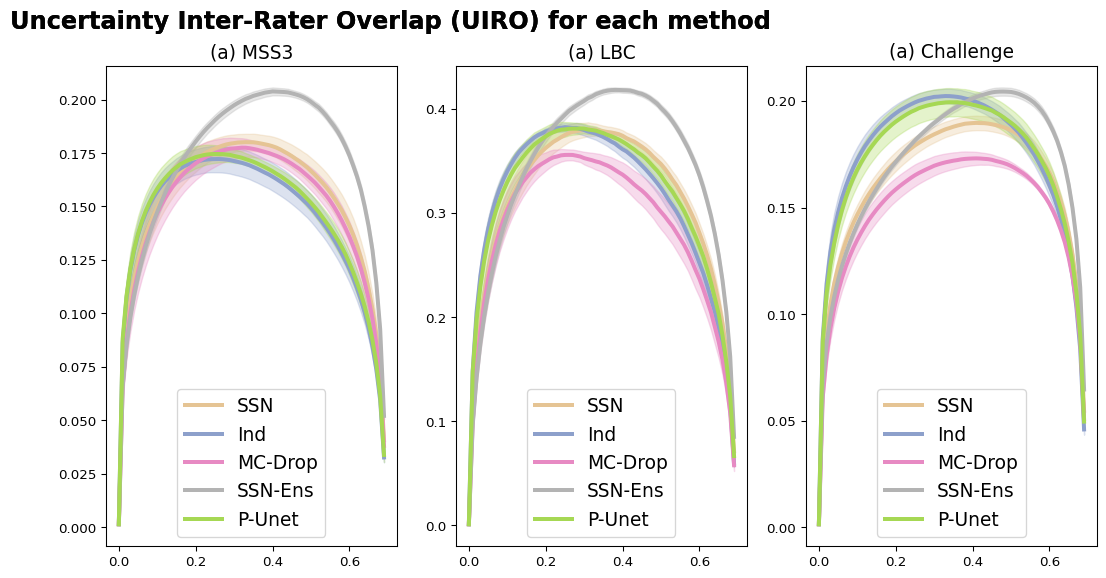

In [36]:
at_value = 0.35
dpi = 96
figsize=(13.33,6.5)
metric = "UIRO_curves"
title = "Uncertainty Inter-Rater Overlap (UIRO) for each method"
fig, axs = plt.subplots(ncols=3, figsize=figsize, dpi = dpi)
plot_metric_for_all_thresholds_95(
    axs[0], mss3_df, metric, 
    marker_point=None,
    ylim=None, xlim=None, title=title, ax_title="(a) MSS3"
)
plot_metric_for_all_thresholds_95(
    axs[1], lbc_df, metric, 
    marker_point=None,
    ylim=None, xlim=None, title=title, ax_title="(a) LBC"
)
plot_metric_for_all_thresholds_95(
    axs[2], challenge_df, metric, 
    marker_point=None,
    ylim=None, xlim=None, title=title, ax_title="(a) Challenge"
)



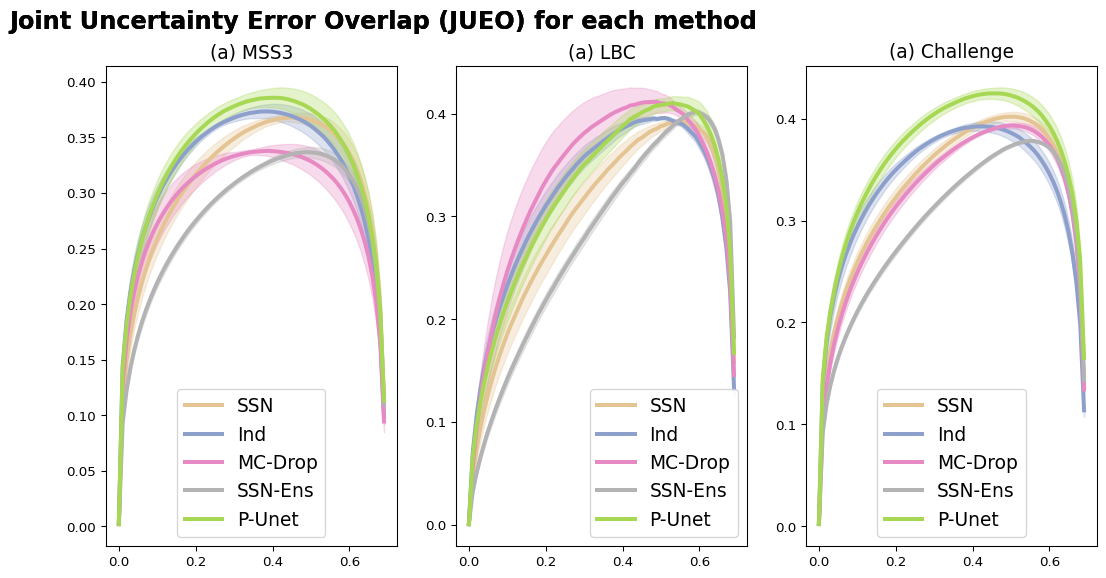

In [37]:
figsize=(13.33,6.5)
metric = "JUEO_curves"
title = "Joint Uncertainty Error Overlap (JUEO) for each method"
fig, axs = plt.subplots(ncols=3, figsize=figsize, dpi = dpi)
plot_metric_for_all_thresholds_95(
    axs[0], mss3_df, metric, 
    marker_point=None,
    ylim=None, xlim=None, title=title, ax_title="(a) MSS3"
)
plot_metric_for_all_thresholds_95(
    axs[1], lbc_df, metric, 
    marker_point=None,
    ylim=None, xlim=None, title=title, ax_title="(a) LBC"
)
plot_metric_for_all_thresholds_95(
    axs[2], challenge_df, metric, 
    marker_point=None,
    ylim=None, xlim=None, title=title, ax_title="(a) Challenge"
)


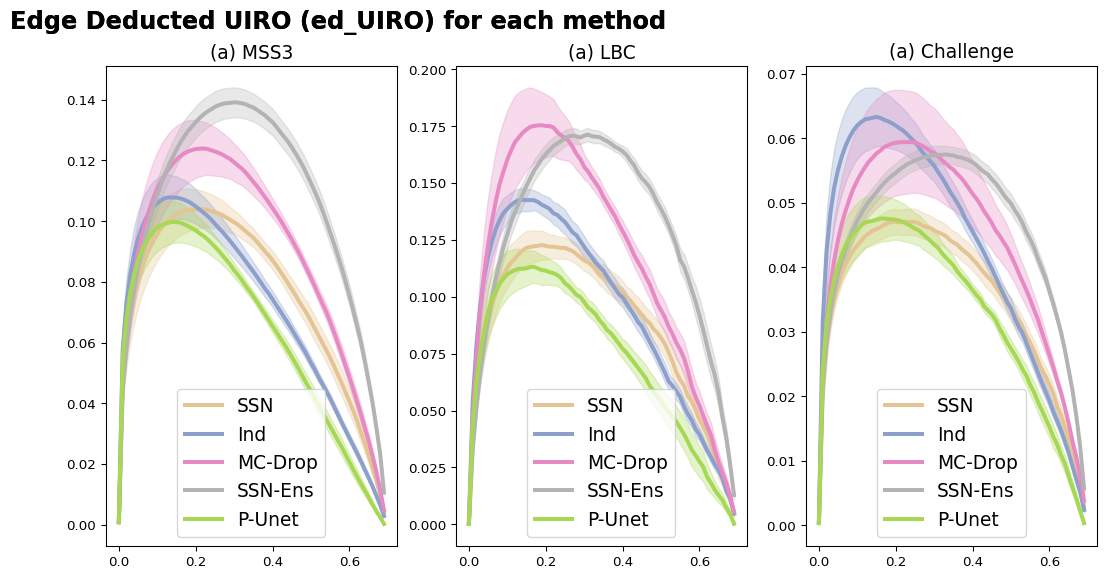

In [38]:
figsize=(13.33,6.5)
metric = "no_edge_uiro_curves"
title = "Edge Deducted UIRO (ed_UIRO) for each method"
fig, axs = plt.subplots(ncols=3, figsize=figsize, dpi = dpi)
plot_metric_for_all_thresholds_95(
    axs[0], mss3_df, metric, 
    marker_point=None,
    ylim=None, xlim=None, title=title, ax_title="(a) MSS3"
)
plot_metric_for_all_thresholds_95(
    axs[1], lbc_df, metric, 
    marker_point=None,
    ylim=None, xlim=None, title=title, ax_title="(a) LBC"
)
plot_metric_for_all_thresholds_95(
    axs[2], challenge_df, metric, 
    marker_point=None,
    ylim=None, xlim=None, title=title, ax_title="(a) Challenge"
)

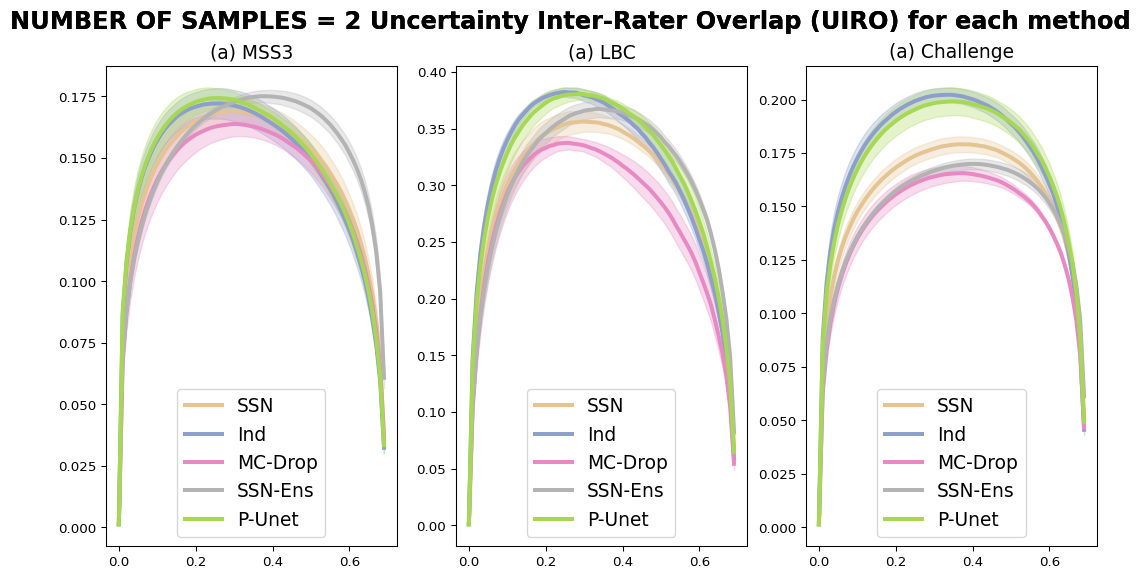

In [43]:
### uncertainty interrater overlap vs number of samples
at_value = 0.35
dpi = 96
figsize=(13.33,6.5)
metric = "UIRO_curves"
title = "NUMBER OF SAMPLES = 2 Uncertainty Inter-Rater Overlap (UIRO) for each method"
fig, axs = plt.subplots(ncols=3, figsize=figsize, dpi = dpi)
plot_metric_for_all_thresholds_95(
    axs[0], mss3_df, metric, 
    marker_point=None,
    ylim=None, xlim=None, title=title, ax_title="(a) MSS3", num_samples=2
)
plot_metric_for_all_thresholds_95(
    axs[1], lbc_df, metric, 
    marker_point=None,
    ylim=None, xlim=None, title=title, ax_title="(a) LBC" , num_samples=2
)
plot_metric_for_all_thresholds_95(
    axs[2], challenge_df, metric, 
    marker_point=None,
    ylim=None, xlim=None, title=title, ax_title="(a) Challenge", num_samples=2
)

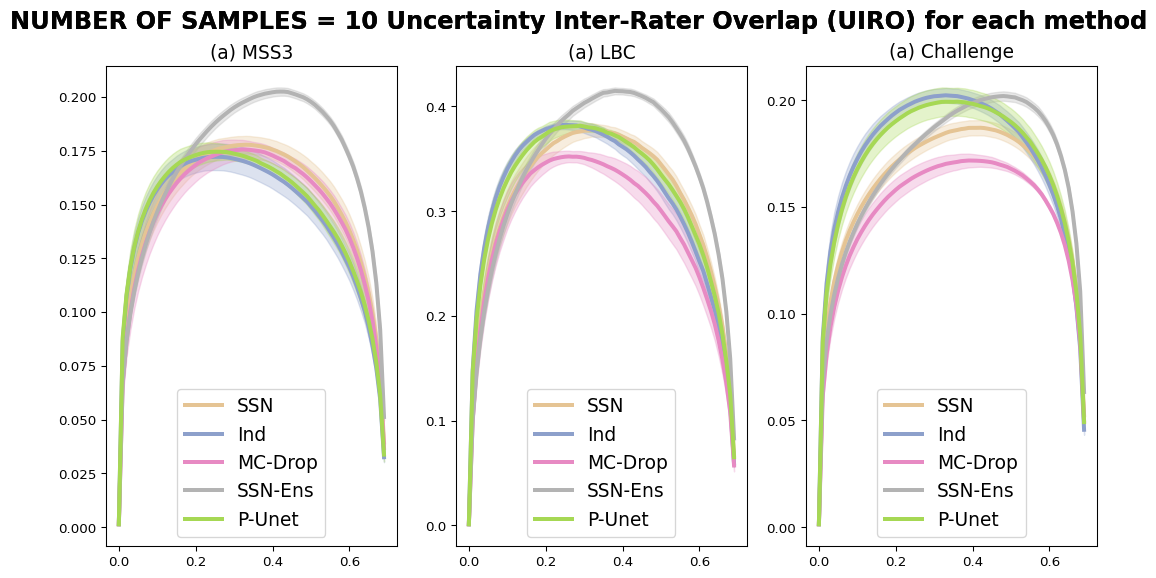

In [45]:
### uncertainty interrater overlap vs number of samples
at_value = 0.35
dpi = 96
figsize=(13.33,6.5)
metric = "UIRO_curves"
title = "NUMBER OF SAMPLES = 10 Uncertainty Inter-Rater Overlap (UIRO) for each method"
fig, axs = plt.subplots(ncols=3, figsize=figsize, dpi = dpi)
plot_metric_for_all_thresholds_95(
    axs[0], mss3_df, metric, 
    marker_point=None,
    ylim=None, xlim=None, title=title, ax_title="(a) MSS3", num_samples=10
)
plot_metric_for_all_thresholds_95(
    axs[1], lbc_df, metric, 
    marker_point=None,
    ylim=None, xlim=None, title=title, ax_title="(a) LBC" , num_samples=10
)
plot_metric_for_all_thresholds_95(
    axs[2], challenge_df, metric, 
    marker_point=None,
    ylim=None, xlim=None, title=title, ax_title="(a) Challenge", num_samples=10
)

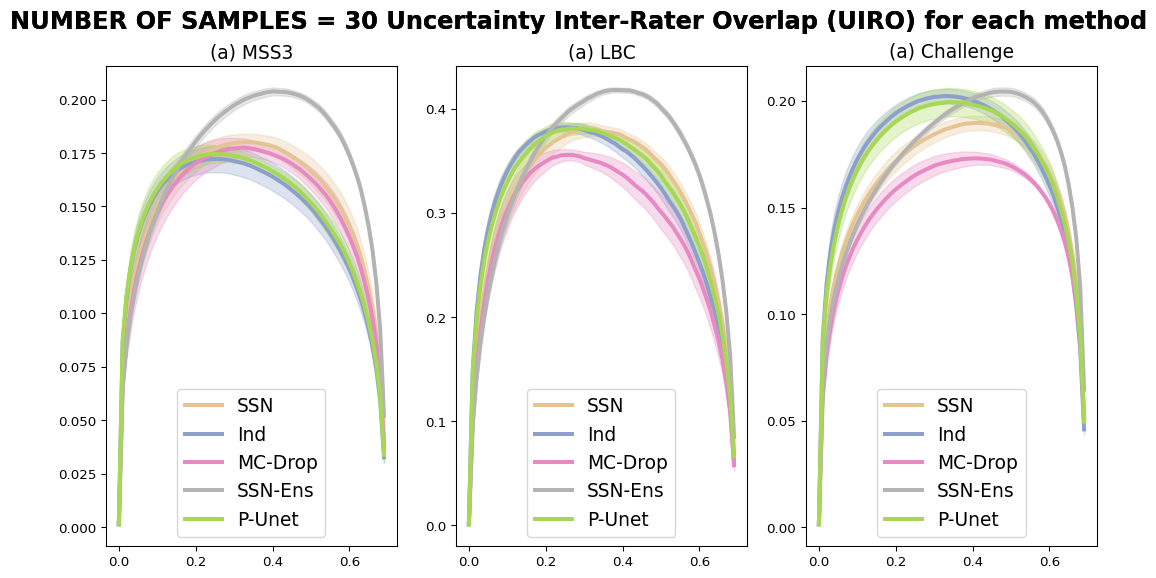

In [47]:
### uncertainty interrater overlap vs number of samples
at_value = 0.35
dpi = 96
figsize=(13.33,6.5)
metric = "UIRO_curves"
title = "NUMBER OF SAMPLES = 30 Uncertainty Inter-Rater Overlap (UIRO) for each method"
fig, axs = plt.subplots(ncols=3, figsize=figsize, dpi = dpi)
plot_metric_for_all_thresholds_95(
    axs[0], mss3_df, metric, 
    marker_point=None,
    ylim=None, xlim=None, title=title, ax_title="(a) MSS3", num_samples=30
)
plot_metric_for_all_thresholds_95(
    axs[1], lbc_df, metric, 
    marker_point=None,
    ylim=None, xlim=None, title=title, ax_title="(a) LBC" , num_samples=30
)
plot_metric_for_all_thresholds_95(
    axs[2], challenge_df, metric, 
    marker_point=None,
    ylim=None, xlim=None, title=title, ax_title="(a) Challenge", num_samples=30
)

### connected component analysis

what do we see? Well we see that the mean uncertainty of lesions that only appear in one rater are much higher for SSN and that there is no overlap as the number of samples gets higher, however, we need to look at what is happening at thresholds as well. However, this is interesting.

TODO: do the rest of the connected component analysis...!!!!!

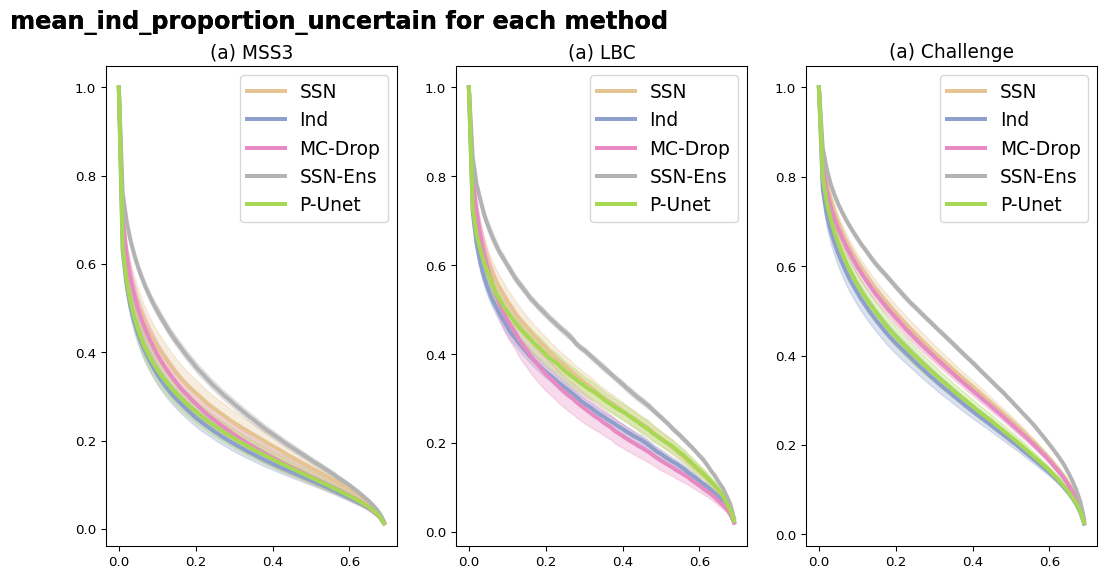

In [39]:
figsize=(13.33,6.5)
metric = "mean_ind_proportion_uncertain"
title = "mean_ind_proportion_uncertain for each method"
fig, axs = plt.subplots(ncols=3, figsize=figsize, dpi = dpi)
plot_metric_for_all_thresholds_95(
    axs[0], mss3_df, metric, 
    marker_point=None,
    ylim=None, xlim=None, title=title, ax_title="(a) MSS3"
)
plot_metric_for_all_thresholds_95(
    axs[1], lbc_df, metric, 
    marker_point=None,
    ylim=None, xlim=None, title=title, ax_title="(a) LBC"
)
plot_metric_for_all_thresholds_95(
    axs[2], challenge_df, metric, 
    marker_point=None,
    ylim=None, xlim=None, title=title, ax_title="(a) Challenge"
)

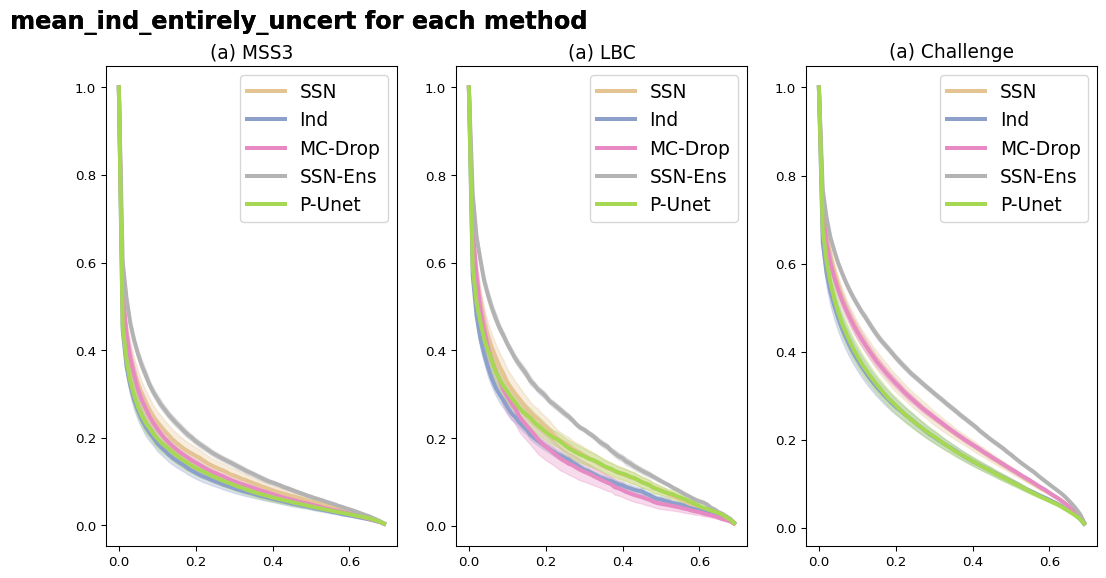

In [40]:
figsize=(13.33,6.5)
metric = "mean_ind_entirely_uncert"
title = "mean_ind_entirely_uncert for each method"
fig, axs = plt.subplots(ncols=3, figsize=figsize, dpi = dpi)
plot_metric_for_all_thresholds_95(
    axs[0], mss3_df, metric, 
    marker_point=None,
    ylim=None, xlim=None, title=title, ax_title="(a) MSS3"
)
plot_metric_for_all_thresholds_95(
    axs[1], lbc_df, metric, 
    marker_point=None,
    ylim=None, xlim=None, title=title, ax_title="(a) LBC"
)
plot_metric_for_all_thresholds_95(
    axs[2], challenge_df, metric, 
    marker_point=None,
    ylim=None, xlim=None, title=title, ax_title="(a) Challenge"
)

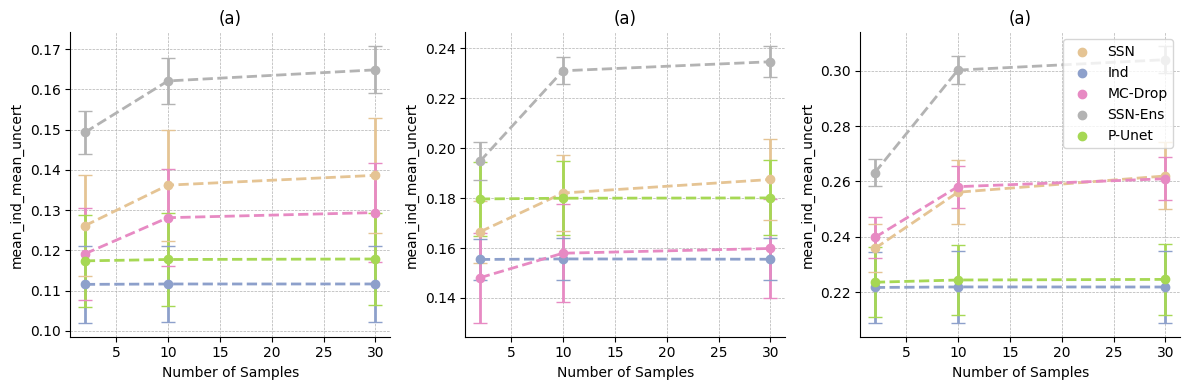

In [42]:
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1)
plot_metric_as_samples_increase(mss3_df, "mean_ind_mean_uncert", r"mean_ind_mean_uncert", "(a)", False, limited_sample_nums=True)
plt.subplot(1,3,2)
plot_metric_as_samples_increase(lbc_df, "mean_ind_mean_uncert", r"mean_ind_mean_uncert", "(a)", False, limited_sample_nums=True)
plt.subplot(1,3,3)
plot_metric_as_samples_increase(challenge_df, "mean_ind_mean_uncert", r"mean_ind_mean_uncert", "(a)", True, limited_sample_nums=True)
plt.tight_layout()

### per individuals analysis

look at JUEO per individual and plot the colour bar with volume, which will be very interesting. Nice.

Now just examining SSN-Ens model, look at the JUEO and the edge variants? I kinda want to know the volume of the edge though to be fair....

for the fazekas paper I can try Maria's PCA idea for the paper that is not a terrible idea to prevent overfitting! We could make it into an MLP?

In [48]:
mss3_df.keys()[200:400]

Index(['no_edge_uiro_curves_t0.27_ss2', 'no_edge_jueo_curves0.27_ss2',
       'no_edge_uiro_curves_t0.28_ss2', 'no_edge_jueo_curves0.28_ss2',
       'no_edge_uiro_curves_t0.29_ss2', 'no_edge_jueo_curves0.29_ss2',
       'no_edge_uiro_curves_t0.30_ss2', 'no_edge_jueo_curves0.30_ss2',
       'no_edge_uiro_curves_t0.31_ss2', 'no_edge_jueo_curves0.31_ss2',
       ...
       'mean_ind_entirely_uncert_t0.49_ss2',
       'mean_ind_proportion_uncertain_t0.49_ss2',
       'mean_ind_entirely_uncert_t0.50_ss2',
       'mean_ind_proportion_uncertain_t0.50_ss2',
       'mean_ind_entirely_uncert_t0.51_ss2',
       'mean_ind_proportion_uncertain_t0.51_ss2',
       'mean_ind_entirely_uncert_t0.52_ss2',
       'mean_ind_proportion_uncertain_t0.52_ss2',
       'mean_ind_entirely_uncert_t0.53_ss2',
       'mean_ind_proportion_uncertain_t0.53_ss2'],
      dtype='object', length=200)

In [54]:
mss3_df.keys()

Index(['Unnamed: 0_ss2', 'rater0_sample_top_dice_ss2',
       'rater0_sample_best_avd_ss2', 'rater1_sample_top_dice_ss2',
       'rater1_sample_best_avd_ss2', 'GED_vol_sorted_ss2',
       'UIRO_curves_t0.00_ss2', 'JUEO_curves_t0.00_ss2',
       'UIRO_curves_t0.01_ss2', 'JUEO_curves_t0.01_ss2',
       ...
       'vds_rater0_sample28_ss30', 'vds_rater1_sample28_ss30',
       'vds_rater_mean_sample28_ss30', 'vds_rater0_sample29_ss30',
       'vds_rater1_sample29_ss30', 'vds_rater_mean_sample29_ss30',
       'sample_vol_skew_ss30', 'GED_dice_sorted_ss30',
       'rater0_best_dice_dsorted_ss30', 'rater1_best_dice_dsorted_ss30'],
      dtype='object', length=1493)

In [80]:
len(mss3_df)

17550

In [81]:
65 * 6 * 5

1950

In [69]:
mss3_df['UIRO_curves_t0.27_ss2'].isna().sum()

15600

In [79]:
(17550-15600)/(65 * 6)

5.0

In [76]:
vs = mss3_df['UIRO_curves_t0.00_ss2'].values

In [77]:
len(vs), np.isnan(vs).sum()#.isnan()

(17550, 15600)

### samples per individual plots
also look at the skew of each distribution. Nice.

These should be like the existing ones that I have in the paper

### RMBS and IR RMBS
are these plots necesarry given we have the mean uncertainty plot? THey are kind of a proxy for the same thing. I guess we can look at calibration on the out of distribution datasets as well.

In [119]:
mss3_df.keys()

Index(['Unnamed: 0_ss2', 'rater0_sample_top_dice_ss2',
       'rater0_sample_best_avd_ss2', 'rater1_sample_top_dice_ss2',
       'rater1_sample_best_avd_ss2', 'GED_vol_sorted_ss2',
       'UIRO_curves_t0.00_ss2', 'JUEO_curves_t0.00_ss2',
       'UIRO_curves_t0.01_ss2', 'JUEO_curves_t0.01_ss2',
       ...
       'vds_rater0_sample28_ss30', 'vds_rater1_sample28_ss30',
       'vds_rater_mean_sample28_ss30', 'vds_rater0_sample29_ss30',
       'vds_rater1_sample29_ss30', 'vds_rater_mean_sample29_ss30',
       'sample_vol_skew_ss30', 'GED_dice_sorted_ss30',
       'rater0_best_dice_dsorted_ss30', 'rater1_best_dice_dsorted_ss30'],
      dtype='object', length=1493)

### pixelwise uncertainty value plots

I will need to go back and collect the full data for this. Look at the pixel values of IR areas, across all the datasets, for each method. Make a comparison. It is important.

### Examination of images to see what is going on
plot specific images of individuals to show inter-rater variability, especially in low dice areas.

look at why we get each metric, what is goign on with edges, and P-Unet vs SSN Ens in particular.

### things to add to the evidence collection process

- [ ] check why the two types of GeD are so similar
- [ ] get the UEO curves for each rater
- [ ] get the results for the ens model
- [ ] get the rmse results.
- [x] get the edge detected UEO curves fixed.